In [1]:
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

In [2]:
import pandas as pd
df = pd.read_csv("emails.csv")
df.shape

(517401, 2)

### extract features

In [3]:
[i.strip() for i in df['message'][0].splitlines()]

['Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>',
 'Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)',
 'From: phillip.allen@enron.com',
 'To: tim.belden@enron.com',
 'Subject:',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'X-From: Phillip K Allen',
 'X-To: Tim Belden <Tim Belden/Enron@EnronXGate>',
 'X-cc:',
 'X-bcc:',
 "X-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail",
 'X-Origin: Allen-P',
 'X-FileName: pallen (Non-Privileged).pst',
 '',
 'Here is our forecast',
 '',
 '']

In [4]:
def email_body(email):
    return ' '.join([mail.strip() for mail in email.splitlines()][15:])

df['text'] = df['message'].apply(email_body)

df.head()

,file,message,text
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes th...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy, Can you send me a schedule of the sal..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.


In [5]:
df = df[["text"]]

### remove duplicate rows

In [6]:
df= df.drop_duplicates()
df.shape

(313217, 1)

### preprocess

In [7]:
def tokenizer(text):

    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

In [8]:
def text_preprocess(text):

    tokens = tokenizer(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)
    
    return text


In [9]:
text_column = 'text'
df[text_column] = df[text_column].apply(text_preprocess)

In [10]:
df= df.drop_duplicates()
df.shape

(294579, 1)

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9 , min_df=0.01)
text_features = tfidf_vectorizer.fit_transform(df['text'])

### plot data before clustering

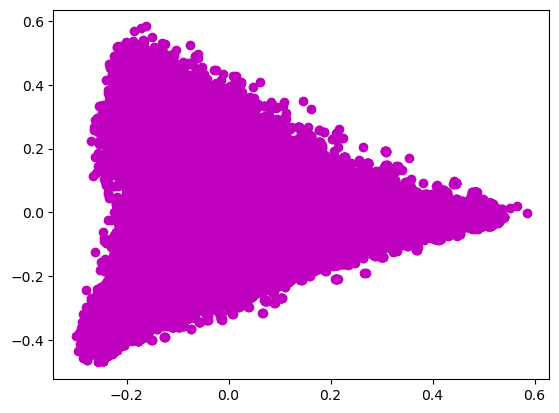

In [26]:
X_dense = np.asarray(text_features.todense())
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm')

### apply k-means

In [44]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters = 2, max_iter = 100, n_init = 15)
labels = clf.fit_predict(text_features)

In [45]:
df['cluster']= labels
cluster_count = df["cluster"].value_counts()
print(cluster_count)

0    255478
1     39101
Name: cluster, dtype: int64


### plot data after clustering

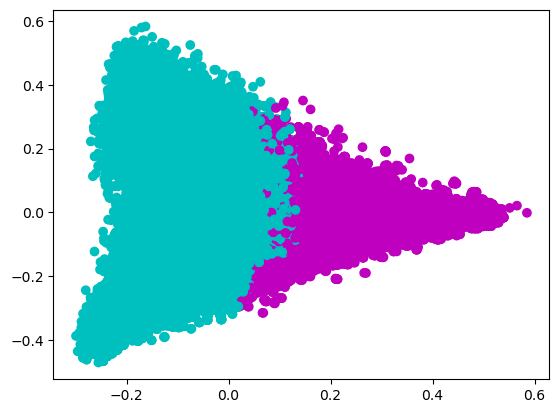

In [46]:
label_colours = ['c',  'm']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

In [47]:
cluster_centers = clf.cluster_centers_
order_centroids = cluster_centers.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(2):
    print("Cluster {}:".format(i))
    for j in order_centroids[i, :10]:
        print("   {}".format(terms[j]))
    print()

Cluster 0:
   subject
   pleas
   pm
   email
   thank
   enron
   messag
   sent
   origin
   cc

Cluster 1:
   john
   mark
   xto
   xcc
   xfrom
   xbcc
   david
   robert
   xfolder
   contenttransferencod



## scores

In [148]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_avg = davies_bouldin_score(text_features.toarray(), labels)
davies_bouldin_avg

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(text_features, labels)
silhouette_avg